# Importing Dependencies

In [22]:
# Manipulating csv file 
import numpy as np
import pandas as pd 

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

#Waring filter 
import warnings
warnings.filterwarnings('ignore')

# Handel temporal data
from datetime import datetime,timedelta

# Model (Facebook Prophet)
from prophet import Prophet 

# Evaluation Metrics 

from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
#Loading dataset 
sales_data = pd.read_csv('/home/rohan/Documents/Project Titanic/Time_Series/Sales_Time_Series/Data/train.csv')

In [24]:
print("Dataset Shape", sales_data.shape)
sales_data.head()

Dataset Shape (3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [25]:
# Aggrigating dataset by family and sales 

sales_agg = sales_data.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])
sales_agg.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.0
33,2013-01-02,AUTOMOTIVE,255.0
66,2013-01-03,AUTOMOTIVE,161.0
99,2013-01-04,AUTOMOTIVE,169.0
132,2013-01-05,AUTOMOTIVE,342.0


In [26]:
# converting to datetime format

sales_agg['date'] = pd.to_datetime(sales_agg['date'], format='%Y-%m-%d')


In [27]:
salesf_pivot = sales_agg.pivot(index='date', columns='family', values='sales')
salesf_pivot.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,2.0,810.0,0.0,180.58900,0.0,186.0,143.0,71.09000,...,0.0,110.801000,25.0,0.0,0.0,42.637000,37.847000,0.0,0.0,0.000000
2013-01-02,255.0,0.0,207.0,72092.0,0.0,26246.31900,0.0,74629.0,23381.0,15754.50000,...,0.0,20871.464028,17204.0,0.0,0.0,13975.884938,5338.111976,0.0,0.0,1526.750002
2013-01-03,161.0,0.0,125.0,52105.0,0.0,18456.48002,0.0,55893.0,18001.0,11172.45500,...,0.0,16597.398113,12568.0,0.0,0.0,10674.393983,3591.388005,0.0,0.0,1094.310994
2013-01-04,169.0,0.0,133.0,54167.0,0.0,16721.96901,0.0,52064.0,18148.0,10143.20900,...,0.0,21625.963055,11303.0,0.0,0.0,10772.515038,4472.965990,0.0,0.0,1293.120995
2013-01-05,342.0,0.0,191.0,77818.0,0.0,22367.76108,0.0,70128.0,23082.0,13734.94501,...,0.0,20879.091050,16819.0,0.0,0.0,13475.009055,5830.073020,0.0,0.0,1245.637004


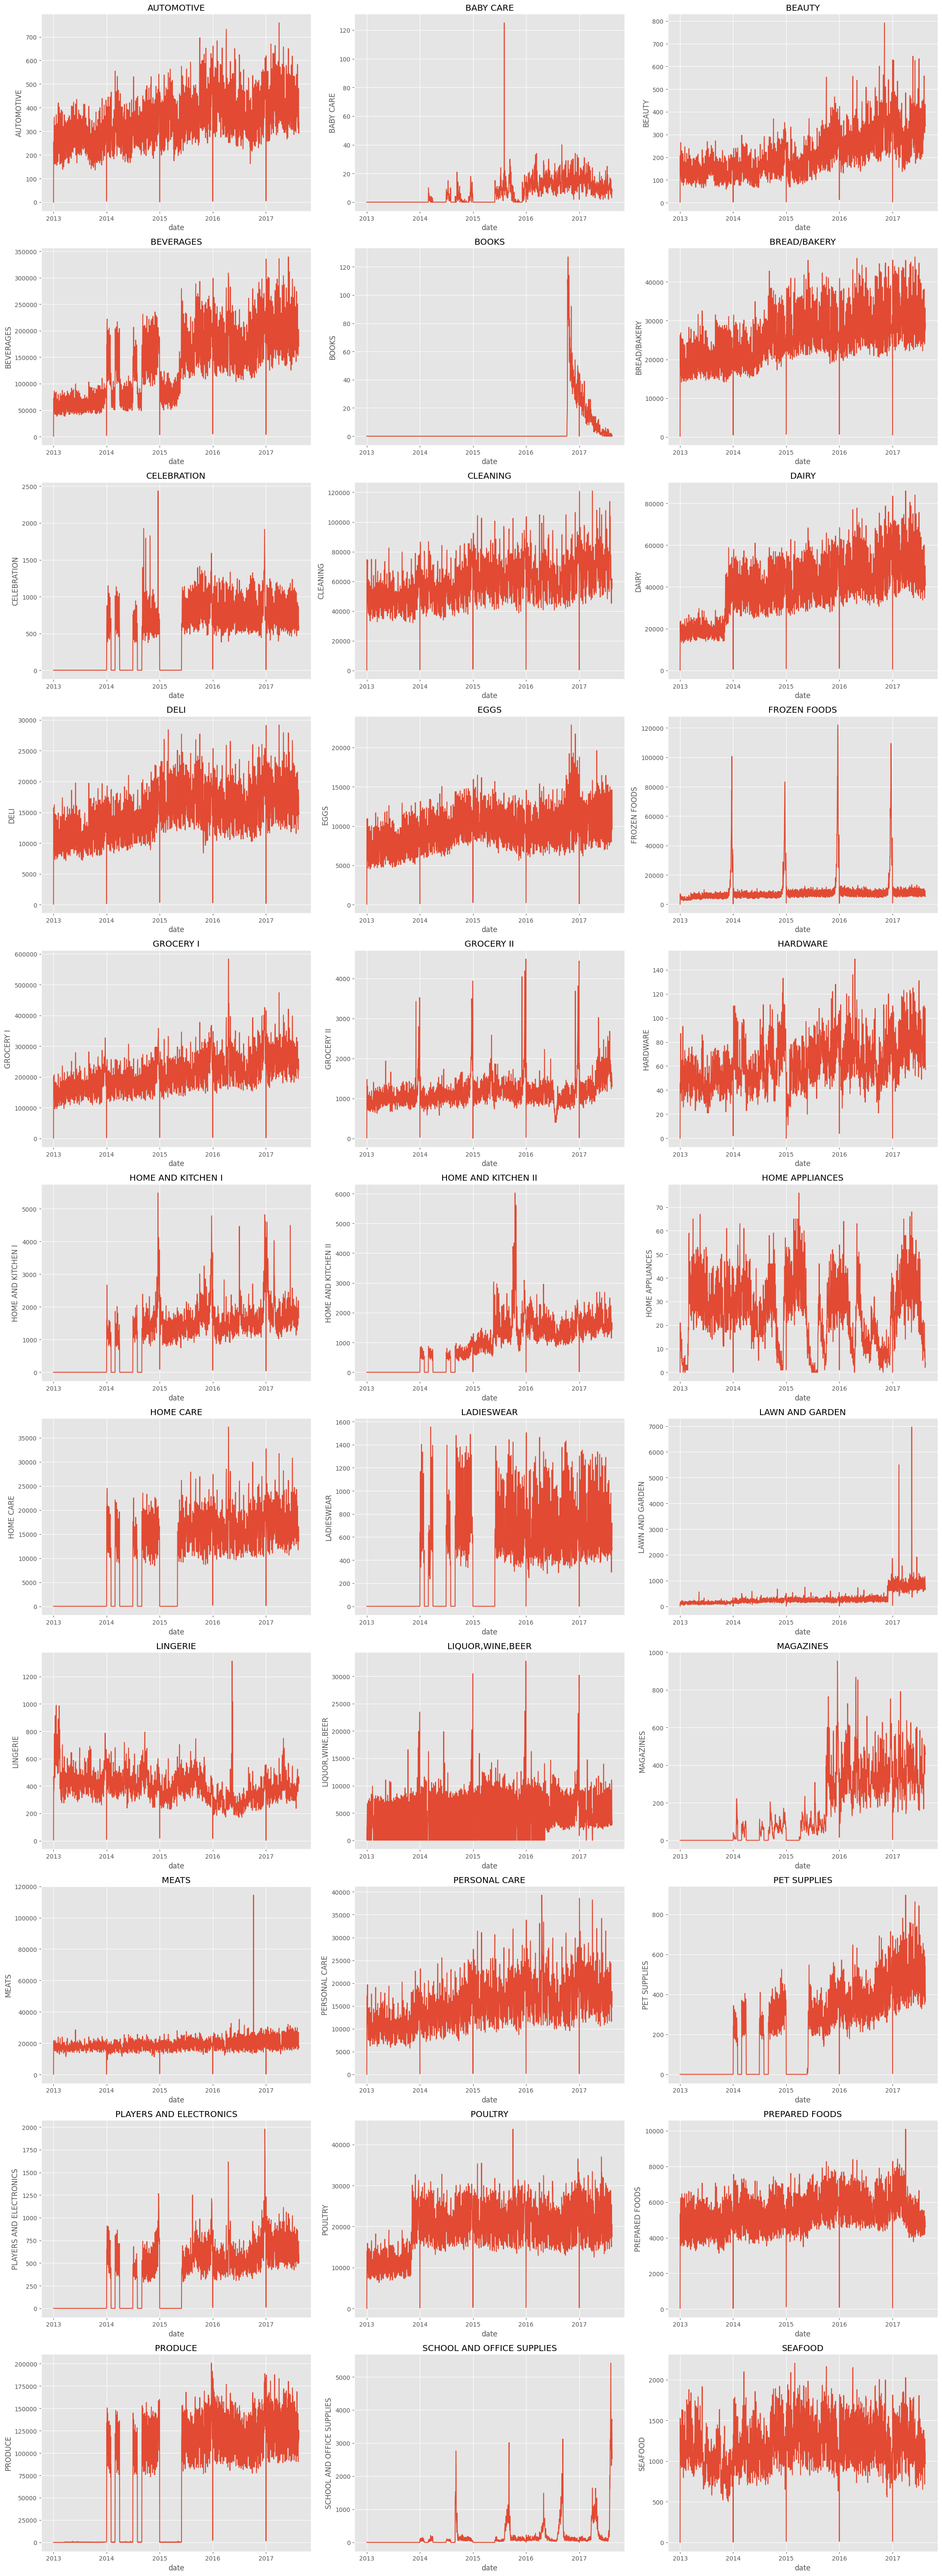

In [28]:
family = sales_agg['family'].unique()
plt.figure(figsize=(22,60))

for i in enumerate(family):
    plt.subplot(11,3, i[0]+1)
    ax = sns.lineplot(salesf_pivot[i[1]])
    for j in ax.containers:
        ax.bar_label(j)
    ax.set_title(i[1])
plt.tight_layout()
plt.show()

# Observation
- At the current stage our data is not ideal for time series forecasting as many catagories have low volume of data and much higher levels of noise
- In many categories there are almost 0 sales before 2015. 
- Further sales are always dropping to 0 at the start of the year which might not be representative of actual data and is noise that can severly impact the model results.
- Need to reduce white noise
- Need to remove outliers with z-score   

In [62]:
# Dropping values from 2013 and 2014 as the data volume is low 

sales_red = salesf_pivot[salesf_pivot.index>='2015-08-15']

In [63]:
# volume selection

clm_len = len(sales_red.columns)

#Keep categories with avg daily sales greater than $1000
sales_red = sales_red[sales_red.columns[sales_red.apply(np.mean) > 1000]]

print("Dropping "+ str(clm_len-len(sales_red.columns))+" columns due to insufficient data volume.")

Dropping 14 columns due to insufficient data volume.


In [64]:
((sales_red == 0).astype(int).sum() / len(sales_red))*100

family
BEVERAGES              0.000000
BREAD/BAKERY           0.000000
CLEANING               0.000000
DAIRY                  0.000000
DELI                   0.000000
EGGS                   0.000000
FROZEN FOODS           0.000000
GROCERY I              0.000000
GROCERY II             0.000000
HOME AND KITCHEN I     0.000000
HOME AND KITCHEN II    0.000000
HOME CARE              0.000000
LIQUOR,WINE,BEER       5.753425
MEATS                  0.000000
PERSONAL CARE          0.000000
POULTRY                0.000000
PREPARED FOODS         0.000000
PRODUCE                0.000000
SEAFOOD                0.000000
dtype: float64

In [65]:
# Imputing values for 'LIQUOR,WINE,BEER' categories where there are zeros
sales_red['LIQUOR,WINE,BEER'] = sales_red['LIQUOR,WINE,BEER'].replace(0, np.nan).interpolate()

In [66]:
((sales_red == 0).astype(int).sum() / len(sales_red))*100

family
BEVERAGES              0.0
BREAD/BAKERY           0.0
CLEANING               0.0
DAIRY                  0.0
DELI                   0.0
EGGS                   0.0
FROZEN FOODS           0.0
GROCERY I              0.0
GROCERY II             0.0
HOME AND KITCHEN I     0.0
HOME AND KITCHEN II    0.0
HOME CARE              0.0
LIQUOR,WINE,BEER       0.0
MEATS                  0.0
PERSONAL CARE          0.0
POULTRY                0.0
PREPARED FOODS         0.0
PRODUCE                0.0
SEAFOOD                0.0
dtype: float64

In [55]:
# Category grouping based on volume
avg_daily_sales = salesf_pivot.apply(np.mean, axis=0).sort_values()

In [56]:
np.percentile(salesf_pivot.apply(np.mean, axis=0).sort_values(),[25,75])

array([  325.91567696, 14603.35570071])

In [57]:
low, mid = np.percentile(salesf_pivot.apply(np.mean, axis=0).sort_values(),[33,66])

In [59]:
# Seperating family by sales volume
Low_volume_sales = list(avg_daily_sales[avg_daily_sales<=low].index)
Mid_volume_sales = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
High_volume_sales = avg_daily_sales[avg_daily_sales>=mid].index

In [61]:
volume = [Low_volume_sales, Mid_volume_sales, High_volume_sales]

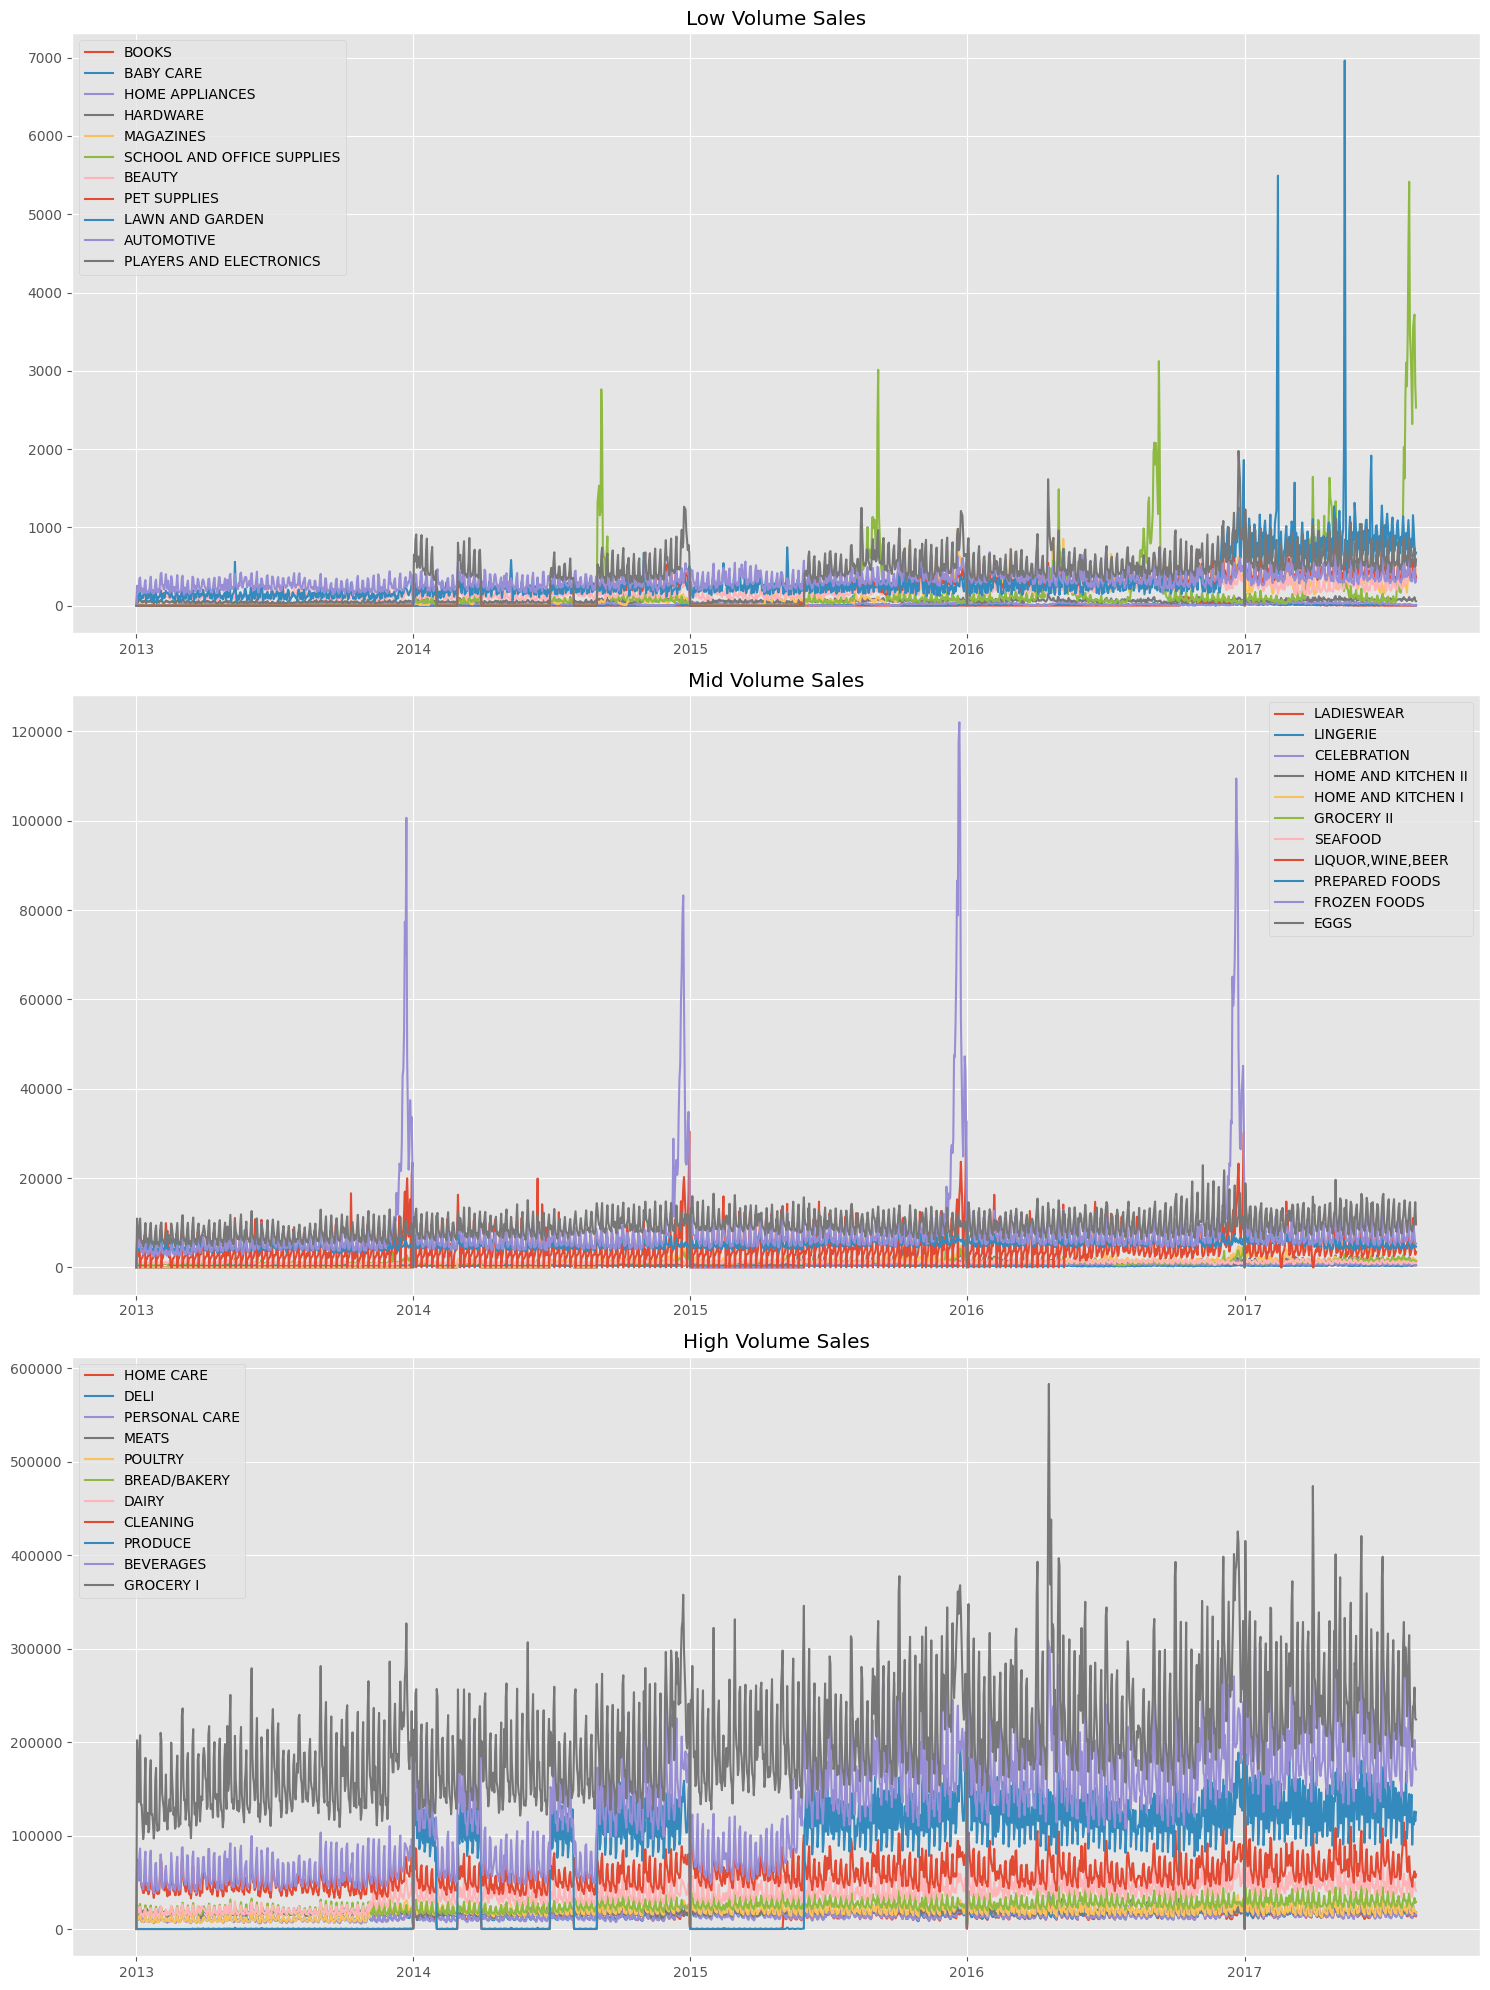

In [72]:
volume = [Low_volume_sales, Mid_volume_sales, High_volume_sales]
title = ['Low Volume Sales', 'Mid Volume Sales', 'High Volume Sales']
plt.figure(figsize=(15,20))
c=0
for i in enumerate(volume):
    plt.subplot(3,1, i[0]+1)
    plt.plot(salesf_pivot[i[1]])
    plt.title(title[c])
    plt.legend(i[1], loc='best') #, bbox_to_anchor=(1.1, 1.1))
    c+=1
plt.tight_layout()
plt.show()

In [ ]:

sales_auto = sales_data[sales_data['family'] == 'BABY CARE'][['date','sales']]

In [8]:
sales_auto.shape

(90936, 2)

In [9]:
sales_auto.isnull().sum()

date     0
sales    0
dtype: int64

In [10]:
sales_auto = sales_auto.groupby('date')['sales'].sum().reset_index()

In [11]:
sales_auto['date'] = pd.to_datetime(sales_auto['date'])

In [12]:
# Finding the the time period of the data

print (f"The tabel contains data from {min(sales_auto.date)} to {max(sales_auto.date)} which is a total of {(max(sales_auto.date)- min(sales_auto.date)).days} days")

The tabel contains data from 2013-01-01 00:00:00 to 2017-08-15 00:00:00 which is a total of 1687 days


In [13]:
sales_auto[sales_auto['sales'] == 0]

,date,sales
0,2013-01-01,0.0
1,2013-01-02,0.0
2,2013-01-03,0.0
3,2013-01-04,0.0
4,2013-01-05,0.0
...,...,...
1063,2015-12-02,0.0
1064,2015-12-03,0.0
1065,2015-12-04,0.0
1066,2015-12-05,0.0


In [12]:
sales_2014 = sales_auto[sales_auto['date'].dt.year == 2014] 

**Checking Data is stationary or not with sample year**

<Axes: xlabel='date'>

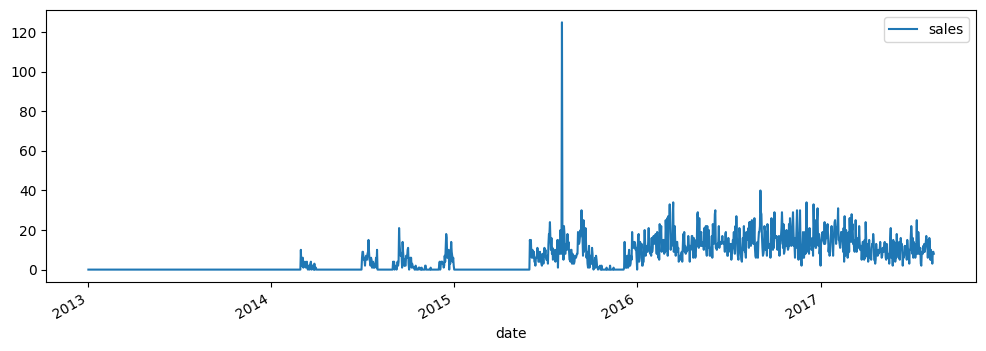

In [22]:
sales_auto.plot(figsize=(12,4))

The graph suggest that our data is stationary as the men and variance do not seem to fluctuate much. We wil be using ADF to confirm this suspicion

In [19]:
# Running the Augmented Dickey-Fuller (ADF) test to determine if our data is stationary
from statsmodels.tsa.stattools import adfuller

In [16]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [17]:
sales_auto.set_index('date', inplace=True)

In [18]:
adf_test(sales_auto)

ADF Statistics: -2.4308802992798553
p- value: 0.1332096554027153
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


**Our data is stationary**

In [374]:
sales_auto.index.min()

Timestamp('2013-01-01 00:00:00')

In [375]:
sales_auto.index.max()

Timestamp('2017-08-15 00:00:00')

# Auto Regressive Model

In [376]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

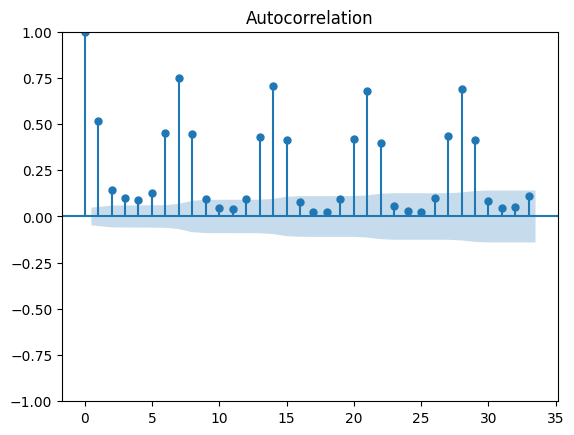

In [377]:
acf = plot_acf(sales_auto["sales"])

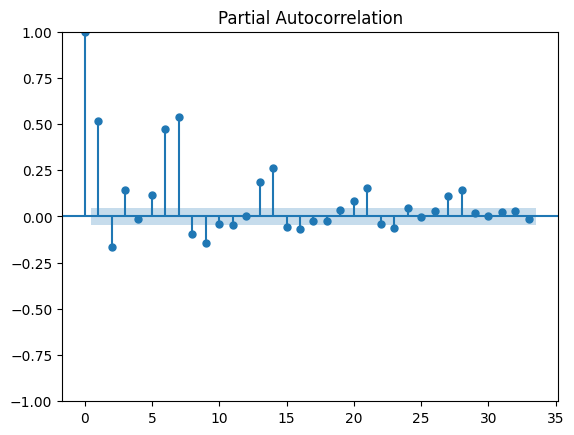

In [378]:
pacf12 = plot_pacf(sales_auto["sales"])

# Taking Train and test data

In [379]:
sales_auto.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1684 entries, 2013-01-01 to 2017-08-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   1684 non-null   float64
dtypes: float64(1)
memory usage: 26.3 KB


In [380]:
# Determining split point for 80 202 train test split
split_point = int(len(sales_auto) * 0.8)
split_point

1347

In [381]:
train_data, test_data = sales_auto[:split_point], sales_auto[split_point:]
test_data

,sales
date,
2016-09-12,238.0
2016-09-13,234.0
2016-09-14,238.0
2016-09-15,163.0
2016-09-16,239.0
...,...
2017-08-11,441.0
2017-08-12,403.0
2017-08-13,481.0


# ARIMA Model

In [427]:
from statsmodels.tsa.arima.model import ARIMA

In [428]:
model_ARIMA = ARIMA(train_data['sales'],order =(2,0,2))

In [429]:
model_Arima_fit=model_ARIMA.fit()

In [430]:
model_Arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1347
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7840.246
Date:                Sun, 26 May 2024   AIC                          15692.492
Time:                        01:48:44   BIC                          15723.726
Sample:                             0   HQIC                         15704.191
                               - 1347                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        315.0821     41.793      7.539      0.000     233.170     396.994
ar.L1          0.9279      0.048     19.433      0.000       0.834       1.021
ar.L2          0.0708      0.048      1.483      0.138      -0.023       0.164
ma.L1         -0.3985      0.042     -9.389      0.000      -0.482      -0.315
ma.L2         -0.5638      0.040    -14.022      0.000      -0.643      -0.485
sigma2      6645.4647    216.170     30.742      0.000    6221.780    7069.150
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               184.79
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [431]:
#prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

2016-09-12 00:00:00
2017-08-15 00:00:00


In [432]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1

In [433]:
predict = model_Arima_fit.predict(start = start,end=end)
predict.index = test_data.index
predict

date
2016-09-12    378.755558
2016-09-13    351.872908
2016-09-14    353.726780
2016-09-15    353.543783
2016-09-16    353.505230
                 ...    
2017-08-11    340.570010
2017-08-12    340.538136
2017-08-13    340.506302
2017-08-14    340.474508
2017-08-15    340.442753
Name: predicted_mean, Length: 337, dtype: float64

In [434]:
pred_levels = pd.Series(predict, index=test_data.index)
pred_levels

date
2016-09-12    378.755558
2016-09-13    351.872908
2016-09-14    353.726780
2016-09-15    353.543783
2016-09-16    353.505230
                 ...    
2017-08-11    340.570010
2017-08-12    340.538136
2017-08-13    340.506302
2017-08-14    340.474508
2017-08-15    340.442753
Name: predicted_mean, Length: 337, dtype: float64

In [435]:
test_data['predictions'] = pred_levels

<Axes: xlabel='date'>

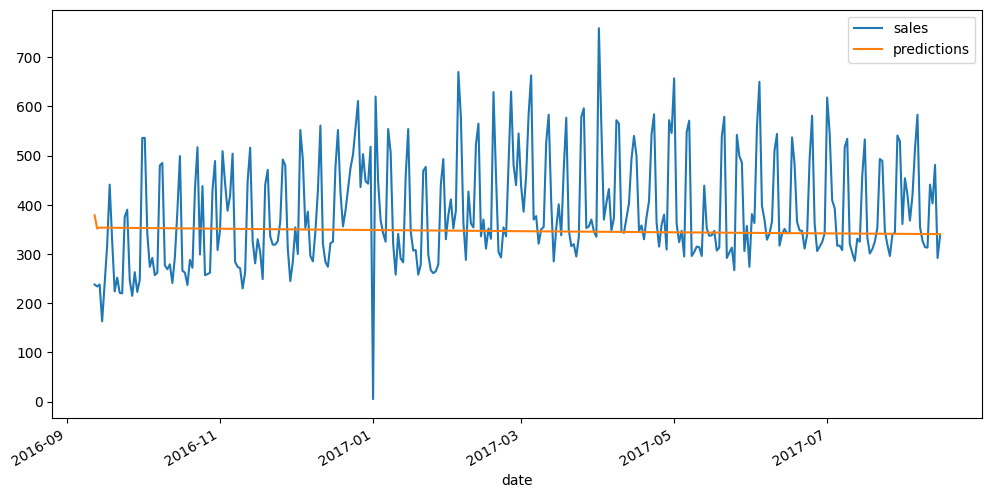

In [436]:
test_data[['sales','predictions']].plot(figsize=(12,6))

In [437]:
test_data

,sales,predictions
date,,
2016-09-12,238.0,378.755558
2016-09-13,234.0,351.872908
2016-09-14,238.0,353.726780
2016-09-15,163.0,353.543783
2016-09-16,239.0,353.505230
...,...,...
2017-08-11,441.0,340.570010
2017-08-12,403.0,340.538136
2017-08-13,481.0,340.506302


# Evaluation with MSE

In [438]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("MAE", mean_absolute_error(test_data['sales'], test_data['predictions']))
print("MSE", mean_squared_error(test_data['sales'], test_data['predictions']))
print("RMSE", np.sqrt(mean_squared_error(test_data['sales'], test_data['predictions'])))
r2_bld = r2_score(test_data['sales'], test_data['predictions'])
print("R2 Score", r2_bld)

MAE 85.82291073217083
MSE 13463.505358647104
RMSE 116.0323461740178
R2 Score -0.14999927194254314
